# **Credit Risk Discrimination Power in a Private Variable**
Analysis of whether a given private variable presents a risk of default for a group of customers.

In [37]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import scipy
import warnings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in exp")
pio.renderers.default = 'png'


## **Extraction**
Obs.: All extraction process was made in a private repository.

In [2]:
# Recuperando as bases dos arquivos específicos
df_p234 = pd.read_pickle(r'\\10.44.250.4\Gestao_Dados\Usuários\Gustavo Meira\DataBases\[25-10-2024] [Risco no Tempo de Titularidade] DF_P234.pkl')
df_motor = pd.read_pickle(r'\\10.44.250.4\Gestao_Dados\Usuários\Gustavo Meira\DataBases\[25-10-2024] [Risco no Tempo de Titularidade] Motor.pkl')
df_recup = pd.read_pickle(r'\\10.44.250.4\Gestao_Dados\Usuários\Gustavo Meira\DataBases\[25-10-2024] [Risco no Tempo de Titularidade] Recup.pkl')

## **Treatment**

#### Main Dataset

In [3]:
p234 = df_p234.copy(deep=True)
motor = df_motor.copy(deep=True)
recup = df_recup.copy(deep=True)

In [4]:
# p234 Treatment
p234 = p234.rename(
    columns={'Id Main__':'COD'}
)
p234 = p234.astype({
    'COD':'float',
    'DATE':'datetime64[ns]',
    'NEO':'datetime64[ns]',
    'CPFL':'datetime64[ns]',
})
p234['COD'] = p234['COD'].astype(float)
p234 = p234[(p234['NEO'].notna()) | (p234['CPFL'].notna())]
p234 = p234[(p234['SYSTEM'] == 'ok') | (p234['SYSTEM'] == 'ver')]
p234 = p234.drop_duplicates(keep='last', subset='COD')
p234 = p234[p234['DATE'] <= '2024-04-30']

# motor Treatment
motor = motor[(motor['STATUS'] == 'Paid') & (motor['DECISION'].isnull())]
motor = motor[(motor['PRODUCT'] == 'Energy') | (motor['PRODUCT'] == 'Daily') | (motor['PRODUCT'] == 'CD')]
motor = motor.astype({
    'COD':'float',
    'ID':'float',
})

# recup Treatment
recup = recup.rename(
    columns={'Id Out__':'ID',
             'Rec_120d_1ªP':'RECUP'
})
recup['OVER'] = np.where(recup['Over_90M07'].notna(), 1, 0)
recup['RECUP'] = np.where(recup['RECUP'].notna(), 1, 0)
recup = recup.astype({
    'ID':'float',
})
recup = recup.iloc[1:]

#### Analysis DataFrame

In [7]:
df = p234.merge(motor, on='COD', how='left')
df = df.merge(recup, on='ID', how='left')
df['COD'] = df['COD'].astype(int)

df = df.loc[df['RECUP'].notna()]
df['COD'] = df['COD'].astype(int)

df['MONTH SECOND'] = (df['DATE'].dt.year - df['SECOND'].dt.year) * 12 + (df['DATE'].dt.month - df['SECOND'].dt.month)
df['MONTH FIRST'] = (df['DATE'].dt.year - df['FIRST'].dt.year) * 12 + (df['DATE'].dt.month - df['FIRST'].dt.month)

In [8]:
def analysis_df(df=df, loc=None, cia=None, statistics='RECUP'):

    if statistics == 'OVER':
        df = df[df['DATE'] <= '2024-03-01']

    total = df.groupby(by=f'MONTH {cia}')[f'MONTH {cia}'].count().iloc[:loc]
    counting = df.groupby(by=f'MONTH {cia}')[f'{statistics}'].sum().iloc[:loc]

    if statistics == 'RECUP':
        return round(100 - (100 * counting / total),2), total, counting
    elif statistics == 'OVER':
        return round(100 * counting / total,2), total, counting

#### Layout

In [15]:
def layout_design(fig:go.Figure, width=700, height=600, x=None, y=None, title=None,
               x_range=None, y_range=None, ) -> None:
    fig.layout = go.Layout(
        width=width,
        height=height,
        plot_bgcolor='white',
        xaxis={'gridcolor':'#cccccc', 'linecolor':'black','title':x, 'range':x_range},
        yaxis={'gridcolor':'#cccccc', 'linecolor':'black','title':y, 'range':y_range},
        title={'text':title},
        barmode='overlay'
    )

#### Graph Functions

In [12]:
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def percent_recup(source=pd.Series) -> None:
    fig = go.Figure()
    fig.add_trace( 
        trace=go.Scatter(
            y=source,
            mode='lines+markers',
            marker=go.scatter.Marker(
                color='#bbbbbb', size=4
            ),
            name='Percentual',
            hovertemplate='Percentual: %{y}%<br>' + 'Month: %{x}<br>',
    ))
    fig.add_trace( 
        trace=go.Scatter(
            x=[0,150],
            y=[source.iloc[:].mean(), source.iloc[:].mean()],
            mode='lines',
            line=go.scatter.Line(
                color='#2cbfd6', dash='9px', 
            ),
            name='Mean',
            hovertemplate='Mean = %{y}<br>'
    ))
    popt, pcov = scipy.optimize.curve_fit(exp_decay, source.index[:151], source.values[:151]);
    fig.add_trace( 
        trace=go.Scatter(
            x=source.index,
            y=exp_decay(source.index, *popt),
            mode='lines',
            line=go.scatter.Line(
                color='#333333', dash='solid'
            ),
            name='Exponencial Decay',
            hovertemplate='x = %{x}<br>'+'f(x) = %{y:.2f}<br>',
    ))
    return fig

# ================================================================================================================

def number_clients(total=pd.Series, nao_pago=pd.Series) -> None:
    fig = go.Figure()
    fig.add_trace( 
        trace=go.Bar(
            y=total,
            marker=go.bar.Marker(
                color='#333333'
            ),
            hovertemplate='Clients: %{y}<br>' + 'Month: %{x}<br>' + 'Percentual: %{customdata:.2f}%<br>'
                                               + f'Total: {total.sum()}',
            customdata=100*total/total.sum(),
            name='Total'
    ))
    fig.add_trace( 
        trace=go.Bar(
            y=nao_pago,
            marker=go.bar.Marker(
                color='#c43636'
            ),
            name='Default',
            hovertemplate='Clients: %{y}<br>' + 'Month: %{x}<br>' + 'Percentual: %{customdata:.2f}%',
            customdata=100*nao_pago/nao_pago.sum(),
    ))
    return fig

# **Credit and Default Analysis by Ownership**

- **New Ownership**:
    - The number of **people lending credit** is significantly **higher in cases of new ownership**.

- **Default Comparison by Company**:
    - **First** has a **default that tends** to approximately $x \to 12.7%$ in longer months, which is higher compared to **Second** (with $x \to 9.6%%$).

- **Default Rate Over Time**:
    - The default rate **decreases significantly** in the first **20 months after securitization**, in both metrics analyzed:
    - **Rec120d**: Represents the default in 120 days after the new ownership. - **Over90M7**: Represents default of more than 90 days, monitored from month 7 after securitization.

- **Comparison between Over90M7 and Rec120d**:
    - The **Over90M7** metric is considerably **more expressive** than **Rec120d**, with a default constant of around **20%**.
<br><br>

---

<br>

> ### **Conclusion**
> The default analysis suggests that the first phase of securitization is crucial to minimize credit risks.<br>
> Visually, it can be concluded that it is a discriminant variable of credit risk.

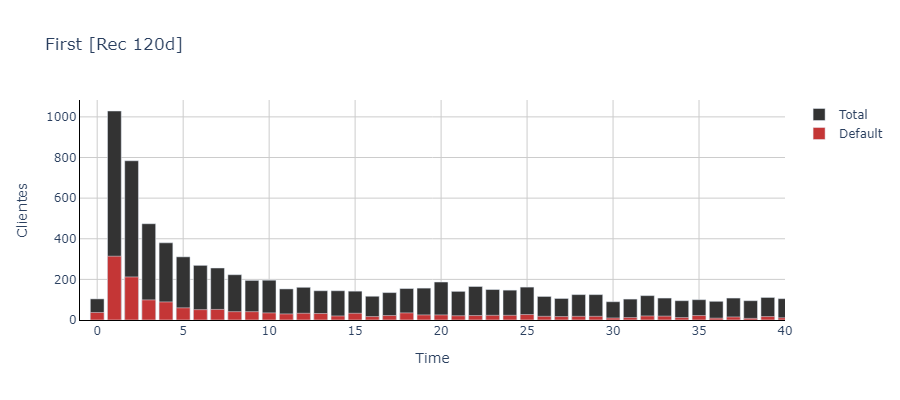

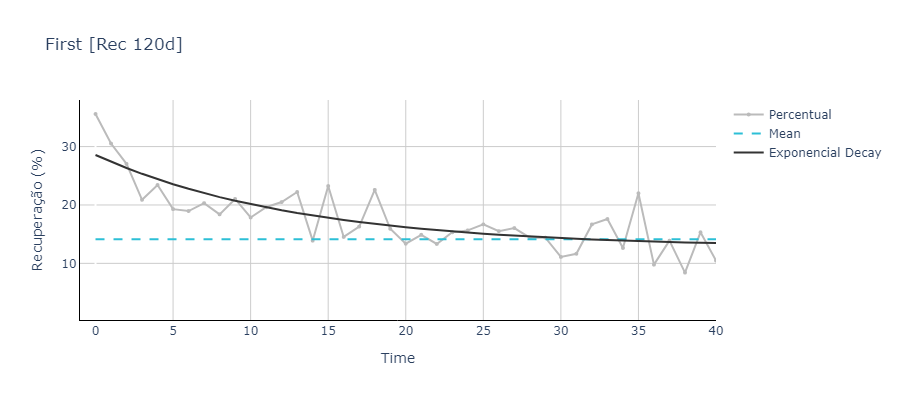

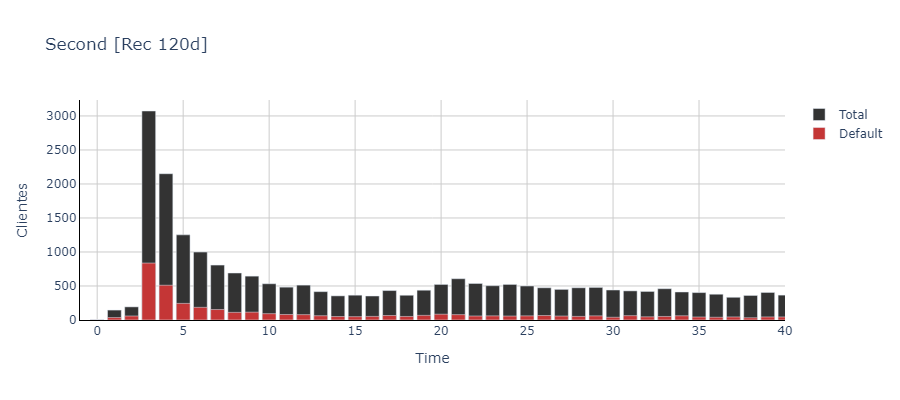

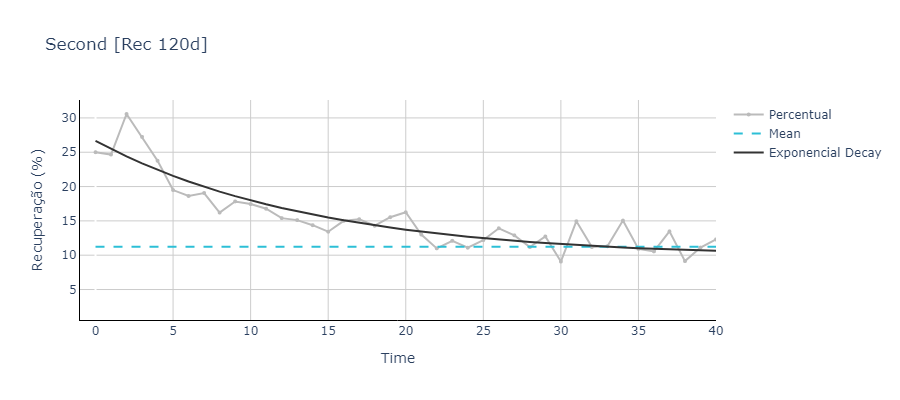

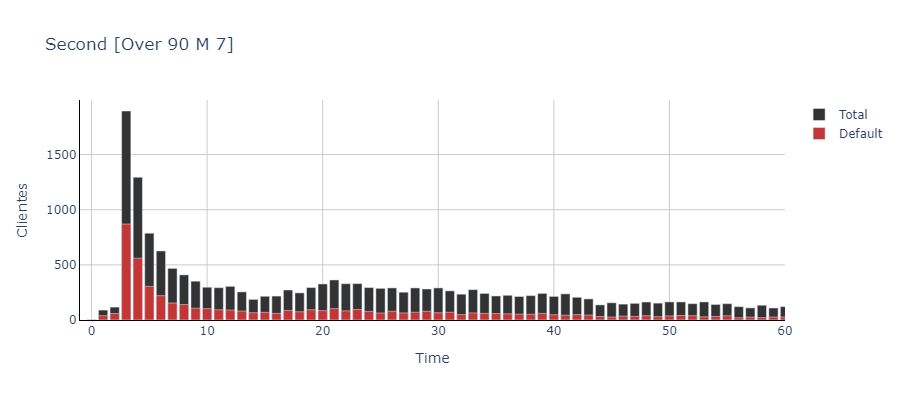

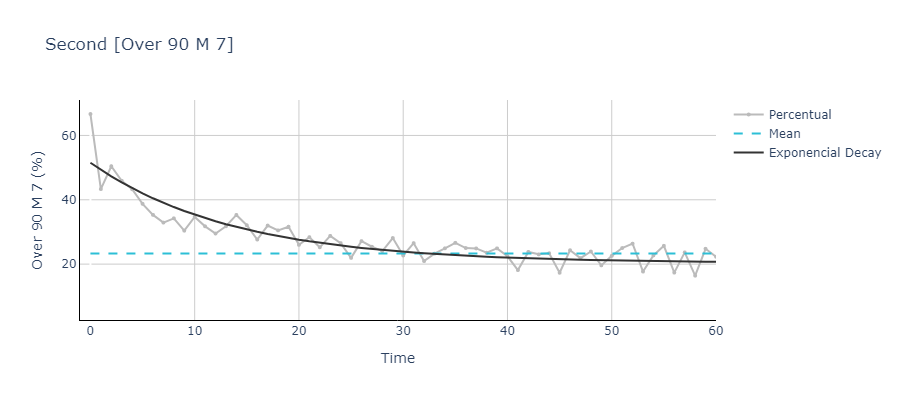

In [22]:
SECOND, month_SECOND, recup_SECOND = analysis_df(df=df, loc=151, cia='SECOND', tipo='RECUP')
FIRST, month_FIRST, recup_FIRST = analysis_df(df=df, loc=151, cia='FIRST', tipo='RECUP')

x_range = [-1, 40]
fig_1 = number_clients(total=month_FIRST, nao_pago=(month_FIRST-recup_FIRST))
layout_design(fig=fig_1, width=900, height=400, x='Time', y='Clientes', title='First [Rec 120d]', x_range=x_range)
fig_2 = percent_recup(source=FIRST)
layout_design(fig=fig_2, width=900, height=400, x='Time', y='Recuperação (%)', title='First [Rec 120d]', x_range=x_range)
fig_3 = number_clients(total=month_SECOND, nao_pago=(month_SECOND-recup_SECOND))
layout_design(fig=fig_3, width=900, height=400, x='Time', y='Clientes', title='Second [Rec 120d]', x_range=x_range)
fig_4 = percent_recup(source=SECOND)
layout_design(fig=fig_4, width=900, height=400, x='Time', y='Recuperação (%)', title='Second [Rec 120d]', x_range=x_range)

# ================================================================================================================

SECOND_over90m7, month_SECOND_over, over_SECOND = analysis_df(df=df, loc=151, cia='SECOND', tipo='OVER')

x_range = [-1, 60]
fig_5 = number_clients(total=month_SECOND_over, nao_pago=over_SECOND)
layout_design(fig=fig_5, width=900, height=400, x='Time', y='Clientes', title='Second [Over 90 M 7]', x_range=x_range)
fig_6 = percent_recup(source=SECOND_over90m7)
layout_design(fig=fig_6, width=900, height=400, x='Time', y='Over 90 M 7 (%)', title='Second [Over 90 M 7]', x_range=x_range)

# ================================================================================================================

figures = [fig_1, fig_2, fig_3, fig_4, fig_5, fig_6]
for fig in figures:
    fig.show()

# **Analysis by Modaity**

- New customers show the same behavior with high exponential decay as the total number of customers, with a **sharp drop in the first few months**, indicating that their credit risk is not interesting for the company, especially the second assessment;
- Only the **second assessment with the Rec120d metric** can be taken into account with great reliability because of the larger probabilistic sample set.

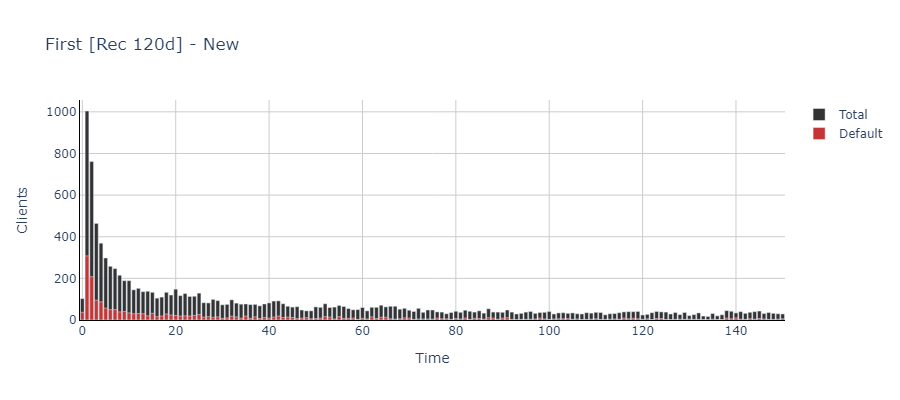

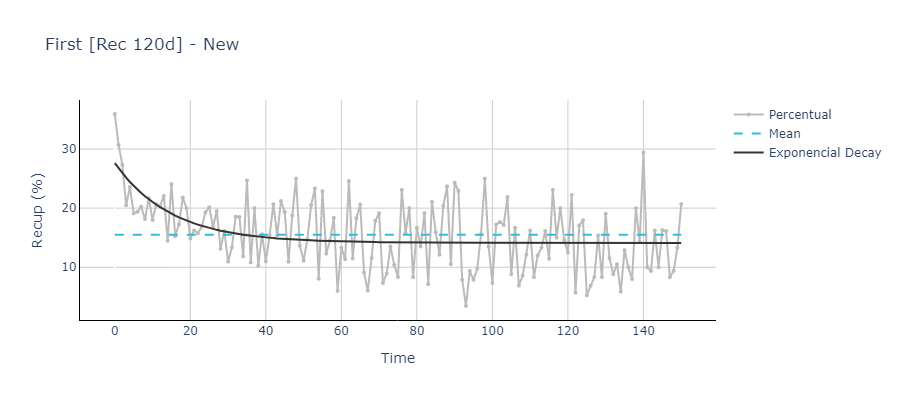

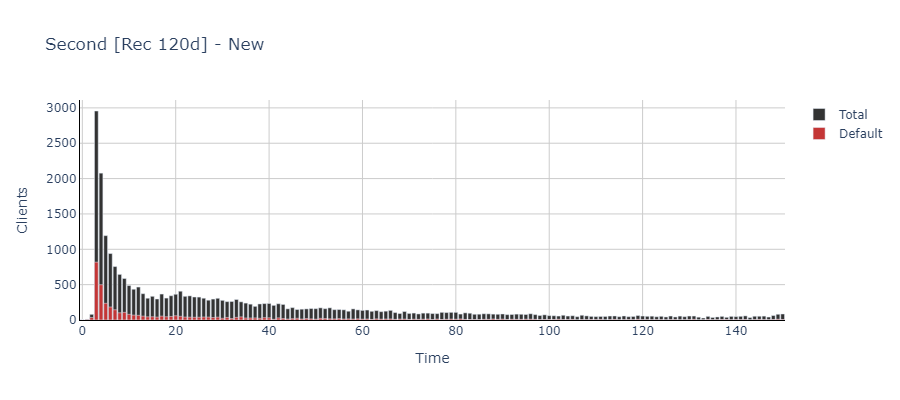

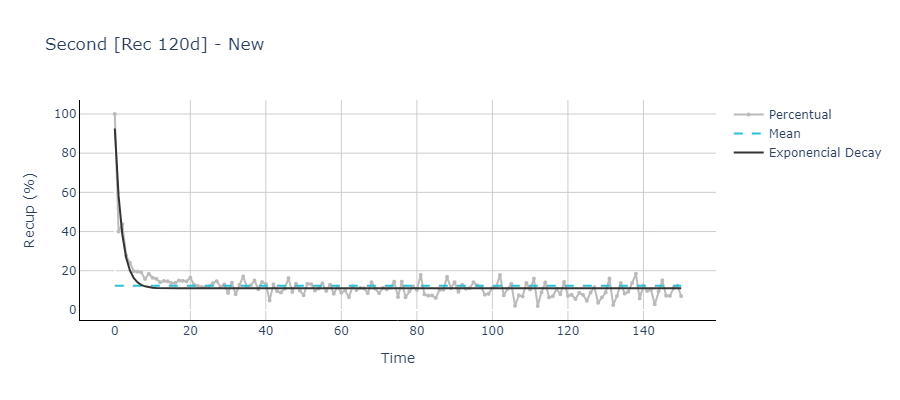

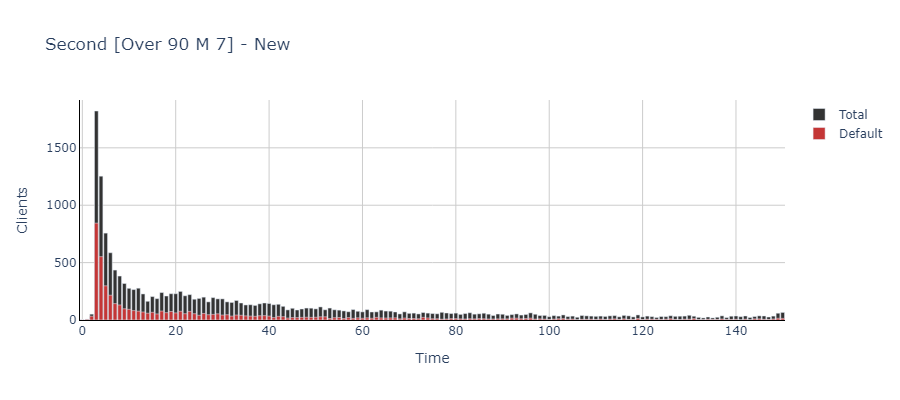

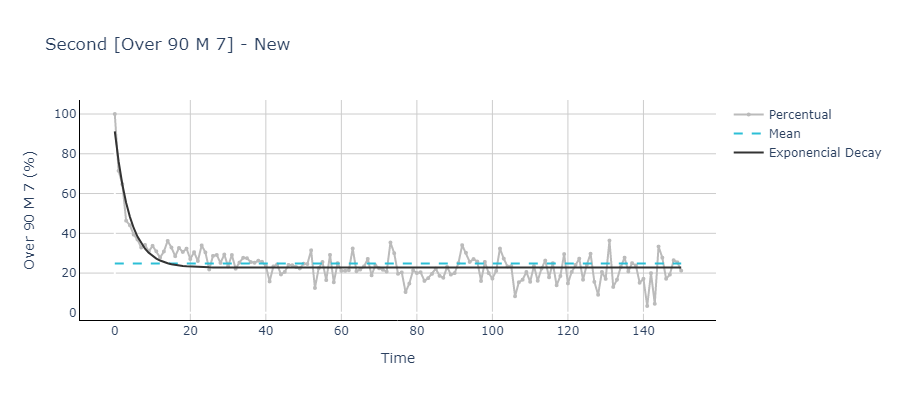

In [26]:
SECOND, mes_SECOND, recup_SECOND = analysis_df(df=df[df['MODALITY'] == 'New'], loc=151, cia='SECOND', tipo='RECUP')
FIRST, mes_FIRST, recup_FIRST = analysis_df(df=df[df['MODALITY'] == 'New'], loc=151, cia='FIRST', tipo='RECUP')

fig_new_1 = number_clients(total=mes_FIRST, nao_pago=(mes_FIRST-recup_FIRST))
layout_design(fig=fig_new_1, width=900, height=400, x='Time', y='Clients', title='First [Rec 120d] - New')
fig_new_2 = percent_recup(source=FIRST)
layout_design(fig=fig_new_2, width=900, height=400, x='Time', y='Recup (%)', title='First [Rec 120d] - New')
fig_new_3 = number_clients(total=mes_SECOND, nao_pago=(mes_SECOND-recup_SECOND))
layout_design(fig=fig_new_3, width=900, height=400, x='Time', y='Clients', title='Second [Rec 120d] - New')
fig_new_4 = percent_recup(source=SECOND)
layout_design(fig=fig_new_4, width=900, height=400, x='Time', y='Recup (%)', title='Second [Rec 120d] - New')

# ================================================================================================================

SECOND_over90m7, mes_SECOND_over, over_SECOND = analysis_df(df=df[df['MODALITY'] == 'New'], loc=151, cia='SECOND', tipo='OVER')

fig_new_5 = number_clients(total=mes_SECOND_over, nao_pago=over_SECOND)
layout_design(fig=fig_new_5, width=900, height=400, x='Time', y='Clients', title='Second [Over 90 M 7] - New')
fig_new_6 = percent_recup(source=SECOND_over90m7)
layout_design(fig=fig_new_6, width=900, height=400, x='Time', y='Over 90 M 7 (%)', title='Second [Over 90 M 7] - New')

# ================================================================================================================

figures = [fig_new_1, fig_new_2, fig_new_3, fig_new_4, fig_new_5, fig_new_6]
for fig in figures:
    fig.show()

# **Discrimination Analysis**

- The discrimination analysis performed with the **IV** (Information Value) shows that the discriminating power of the variable is **moderate**.
- When **merging the data set into 2 classes**, **weak discrimination** is observed;
- The discriminating information contained in the first 8 months of ownership is the same as in the remaining months!
<br><br>

---

<br>

> ### **Conclusion**
> It can be concluded that, although it is a discriminating variable of credit risk, it is considered moderate/low by a univariate assessment.

### DataFrames

In [ ]:
SECOND_OVER = pd.DataFrame()

SECOND_OVER['Months'] = mes_SECOND_over.index
SECOND_OVER['Total'] = mes_SECOND_over.values
SECOND_OVER['Good'] = over_SECOND.values
SECOND_OVER['Bad'] = SECOND_OVER['Total'] - SECOND_OVER['Good']

SECOND_OVER['Good (row)'] = round(SECOND_OVER['Good']/SECOND_OVER['Total'],2)
SECOND_OVER['Bad (row)'] = round(SECOND_OVER['Bad']/SECOND_OVER['Total'],2)

SECOND_OVER['Good (col)'] = round(SECOND_OVER['Good']/SECOND_OVER['Good'].sum(),6)
SECOND_OVER['Bad (col)'] = round(SECOND_OVER['Bad']/SECOND_OVER['Bad'].sum(),6)

SECOND_OVER['B/M'] = round(SECOND_OVER['Good']/SECOND_OVER['Bad'],2)
SECOND_OVER['WOE'] = round(np.log(SECOND_OVER['Good (col)']/SECOND_OVER['Bad (col)']),6)
SECOND_OVER['IV'] = round((SECOND_OVER['Good (col)']-SECOND_OVER['Bad (col)'])*SECOND_OVER['WOE'],6)

INFOS_SECOND_OVER = pd.DataFrame(columns=SECOND_OVER.columns)
INFOS_SECOND_OVER.loc['Sum'] = SECOND_OVER.sum(numeric_only=True)

# ======================================================================================================

SECOND_OVER_CAT = SECOND_OVER.copy(deep=True)

i = 8

interval_1 = SECOND_OVER_CAT[(SECOND_OVER_CAT['Months'] >= 3) & (SECOND_OVER_CAT['Months'] <= i)]['IV'].sum()
interval_2 = SECOND_OVER_CAT[(SECOND_OVER_CAT['Months'] > i)]['IV'].sum()

SECOND_OVER_CAT = pd.DataFrame({
    'Months': [f'0 - {i}', f'{i+1} - 150'],
    'IV': [interval_1, interval_2]
})

# ======================================================================================================

SIDDIQI = pd.DataFrame(
    index=['IV < 0,1','0,1 ≤ IV ≤ 0,3','IV > 0,3','IV > 0,5'],
    data={'Siddiqi':['Weak','Medium','Strong','Super Strong']}
)

In [47]:
display(SIDDIQI)

,Siddiqi
"IV < 0,1",Weak
"0,1 ≤ IV ≤ 0,3",Medium
"IV > 0,3",Strong
"IV > 0,5",Super Strong
